In [1]:
%pylab inline
import numpy as np
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

import sys
sys.path.append('../../core/')
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def F1_fixed(a,b,W):
    
    F1 = np.empty(*W.shape)
    
    for i in range(len(W)):
        a_hat = np.quantile(a, 1-W[i])
        F1[i] = F1_score(a,b,a_hat,a_hat)
    
    return F1

In [8]:
loss_types = ['MSE', 'RE', 'OW','AOW']
taus = [2.0,4.0,6.0,8.0,10.0]
Omega = np.logspace(-4,-1,20)
n_restarts = 20
path = '../../saved_results/kol/'

In [10]:
if True:
    
    Results = {}

    for loss_type in loss_types:
        for tau in taus:

            filename = path+'results_loss_'+loss_type+'_tau'+str(tau)+'.npy'
            Results[loss_type, tau] = np.load(filename, allow_pickle=True).item()

            Results[loss_type,tau]['NN_mean'] = np.mean(np.vstack([Results[loss_type, tau]['NN_'+str(j+1)] 
                                                         for j in range(n_restarts)]), axis=0)

            Results[loss_type,tau]['error'] = np.vstack([Results[loss_type, tau]['true'].flatten()-
                                                         Results[loss_type, tau]['NN_'+str(j+1)]
                                                         for j in range(n_restarts)])

In [11]:
m_tv = int(0.6*len(Results[loss_types[0],tau]['true']))
sample_rate = 1

W = np.logspace(-4,0,101)
Q = {}

for i in range(len(taus)):
    
    true = Results[loss_types[0],taus[i]]['true'][m_tv::sample_rate]
    
    for j in tqdm(range(len(loss_types))):
        
        Q[loss_types[j],taus[i]] = np.empty((n_restarts, len(W)))
        for k in range(n_restarts):
            
            pred = Results[loss_types[j],taus[i]]['NN_'+str(k+1)][m_tv::sample_rate]
            Q[loss_types[j],taus[i]][k,...] = F1_fixed(true,pred,W)

100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


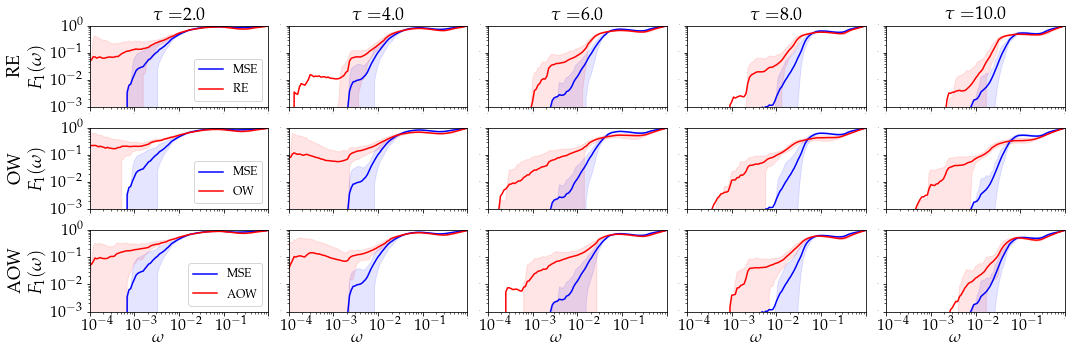

In [15]:
figure(figsize = (15,5))
label_fs = 18
alpha = 0.1
pct = 10

for i in range(len(taus)):
    for j in range(len(loss_types)-1):

        ax=subplot2grid((3,len(taus)),(j,i))
        
        plot(W, np.mean(Q[loss_types[0],taus[i]],axis=0), 'b', label='MSE')
        fill_between(W, 
                     np.percentile(Q[loss_types[0],taus[i]],pct,axis=0), 
                     np.percentile(Q[loss_types[0],taus[i]],100-pct,axis=0), 
                     color='b', alpha=0.1)

        plot(W, np.mean(Q[loss_types[j+1],taus[i]],axis=0), 'r', label=loss_types[j+1])
        fill_between(W, 
                     np.percentile(Q[loss_types[j+1],taus[i]],pct,axis=0), 
                     np.percentile(Q[loss_types[j+1],taus[i]],100-pct,axis=0), 
                     color='r', alpha=0.1)
        
        xlim(W[0], W[-1])

        if j==2:
#             xlabel(r'$\omega$', fontsize = label_fs)
            xticks(fontsize = 0)
        else:
            xticks(fontsize=0)
        if j==0:
            title(r'$\tau=$'+str(taus[i]), fontsize = label_fs)
#             legend(loc = 'upper left', fontsize = label_fs-6, ncol=2)

        if i==0:
            label = r'$F_1 ( \omega )$'
            label = r''+loss_types[j+1]+'\n$F_1 ( \omega )$'
            ylabel(label, fontsize = label_fs)
            yticks(fontsize = label_fs-2)
            legend(loc = 'lower right', fontsize = label_fs-6, ncol=1)
        else:
            yticks(fontsize=0)
            
        yscale('log')
        xscale('log')
        ylim([1e-3,1])
        
        if j == 2:
            text(10**-4.2, 10**-3.7, r'$10^{-4}$', fontsize = label_fs-2)
            text(10**-3.2, 10**-3.7, r'$10^{-3}$', fontsize = label_fs-2)
            text(10**-2.2, 10**-3.7, r'$10^{-2}$', fontsize = label_fs-2)
            text(10**-1.2, 10**-3.7, r'$10^{-1}$', fontsize = label_fs-2)
            text(10**-2.6, 10**-4.1, r'$\omega$', fontsize = label_fs-2)
#         xlim([1e-3,0.1])

tight_layout()